In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import sys
sys.path.insert(1, "../python/functions")
sys.path.insert(2, "../python/architecture")

In [3]:
from data_prep_functions import mnist_prep
from model_functions import *
from plotting_functions import *
import no_gpu
import reproducible

In [4]:
X_train, X_val, y_train, y_val = mnist_prep()

In [5]:
# use samller dataset for increased speed
X_train_small = X_train[:1000, :]
X_val_small = X_val[:500, :]
y_train_small = y_train[:1000]
y_val_small = y_val[:500]

n_cols = X_train_small.shape[1]

# EnKF

In [6]:
X_train = X_train_small
X_test = X_val_small
y_train = y_train_small
y_test = y_val_small

In [7]:
batch_size = 50
epochs = 20
particles = 500
early_stopping = False
early_stopping_diff = 0.001
batch_normal = False # evtl. noch einbauen, obwohl im Paper nicht gemacht (aber Achtung mit den Dimensionen unten!!!)
shuffle = True
randomization = False

In [8]:
layers = 5
neurons = [128, 128, 64, 32, 10]
n_cols = X_train.shape[1]

In [9]:
delta = 0.005
h_0 = 2
epsilon = 0.5

In [10]:
n = len(X_train)
num_batches = int(np.ceil(n / batch_size))
batch_indices = np.cumsum([0] + list(np.ones(num_batches) * batch_size))
batch_indices[-1] = n

In [11]:
model_dict = {}
weights_dict = {}
y_pred_dict = {}
jacobian_dict = {}
weights_vector_dict = {}
train_acc_dict = {}
test_acc_dict = {}
iteration_dict = {}

# init_model already has weights and biases following the Glorot distribution
# it can already be used to predict and evaluate, but it is very bad (<10% accuracy)
# only used to determine shapes and shape_elements via its weights
init_model = nn_model_structure(layers = layers,
                                neurons = neurons,
                                n_cols = n_cols)
init_model = nn_model_compile(init_model,
                              optimizer = "sgd")
weights = init_model.get_weights()
# shape contains the shapes of the weight matrices and bias vectors as a list of arrays
shapes = [np.array(params.shape) for params in weights]
# shape_elements contains the indices of the weights as a vector and tells where to cut
shape_elements = np.cumsum([0] + [np.prod(shape) for shape in shapes])

In [12]:
for i in range(particles):
    # just an initial model with the correct structure regarding neurons, layers, activation functions, Glorot initialization
    model = nn_model_structure(layers = layers,
                               neurons = neurons,
                               n_cols = n_cols)
    model = nn_model_compile(model,
                             optimizer = "sgd")
    # for every particle write the model in a dictionary
    model_dict["model_{}".format(str(i+1))] = model
    
    # for every particles write the weights and biases in a dictionary
    weights_dict["model_{}".format(str(i+1))] = model_dict["model_{}".format(str(i+1))]\
                                                    .get_weights()
    
    train_acc_dict["model_{}".format(str(i+1))] = []
    test_acc_dict["model_{}".format(str(i+1))] = []
    iteration_dict["model_{}".format(str(i+1))] = []

In [13]:
# mean_model as the model with the mean of the weights of all particle models
mean_weights = list(np.mean(list(weights_dict.values()), axis = 0))
mean_model = init_model
mean_model.set_weights(mean_weights)

mean_model_train_acc = np.array(mean_model.evaluate(X_train, y_train)[1])
mean_model_test_acc = np.array(mean_model.evaluate(X_test, y_test)[1])

16/16 [==============================] - 0s 688us/step - loss: 2.3036 - accuracy: 0.1000


In [14]:
import time
start_time = time.time()

In [15]:
# loop over all epochs
for epoch in range(epochs):
    # shuffle the data
    if shuffle:
        indices = y_train.sample(frac=1).index
        X_batches = [X_train[indices][int(batch_indices[i]):int(batch_indices[i+1])] for i in range(len(batch_indices)-1)]
        y_batches = [y_train.iloc[indices].reset_index(drop = True)[int(batch_indices[i]):int(batch_indices[i+1])] for i in range(len(batch_indices)-1)]   
    # loop over all batches
    for b in range(num_batches):    
        for i in range(particles):
            # set new weights for model
            model_dict["model_{}".format(str(i+1))].set_weights(weights_dict["model_{}".format(str(i+1))])
            
            # for every particle write the predictions on the training batches in a dictionary
            y_pred_dict["model_{}".format(str(i+1))] = model_dict["model_{}".format(str(i+1))]\
                                                            .predict(X_batches[b])

            # for every particle write the Jacobian in a dictionary
            jacobian_dict["model_{}".format(str(i+1))] = (-1) * np.multiply(np.array(y_batches[b]), 
                                                                            np.array(1 / (y_pred_dict["model_{}".format(str(i+1))] + delta)))
            
        # compute the mean of the predictions
        y_pred_mean = np.mean(list(y_pred_dict.values()), axis = 0)
        
        # compute the matrix D elementwise
        d = np.zeros(shape = (particles, particles))
        for k in range(particles):
            y_pred_centered = y_pred_dict["model_{}".format(str(k+1))] - y_pred_mean
            for j in range(particles):
                d[k][j] = np.sum(np.multiply(y_pred_centered, jacobian_dict["model_{}".format(str(j+1))]))
        d = np.transpose(d)                              
        # compute the scalar h_t
        h_t = h_0 / (np.sqrt(np.sum(d**2)) + epsilon)
        
        # Reshape the weights and biases so that they are no longer matrices and vectores, but now one single vector
        for i in range(particles):
            weights_array = np.array([])
            for j in range(len(weights_dict["model_{}".format(str(i+1))])):
                weights_array = np.append(weights_array, np.reshape(weights_dict["model_{}".format(str(i+1))][j], (1, -1)).ravel())
            weights_vector_dict["model_{}".format(str(i+1))] = weights_array
          
        # matrix with particle parameters as row vectors
        weights_all_ptcls = np.array(list(weights_vector_dict.values()))

        # compute the matrix with the updates for each particle
        weights_all_ptcls = weights_all_ptcls - h_t * np.matmul(d, weights_all_ptcls)

        for i in range(particles):
            # write the updates back into the dictionary
            weights_vector_dict["model_{}".format(str(i+1))] = weights_all_ptcls[i]
            # reshape the updates, so that they are of the original matrx and vector shape
            for l in range(len(shape_elements)-1):
                start = shape_elements[l]
                end = shape_elements[l+1]
                weights_dict["model_{}".format(str(i+1))][l] = np.reshape(weights_vector_dict["model_{}".format(str(i+1))][start:end], tuple(shapes[l]))
            if randomization:
                # add randomization/ noise to each particle
                new_weights = []
                # standard deviation for scaled Glorot distribution
                for s in range(len(shapes)):
                    if shapes[s].shape[0] == 2:
                        fan_in = shapes[s][0]
                        fan_out = shapes[s][1]
                    if shapes[s].shape[0] == 1:
                        fan_in = shapes[s-1][0]
                        fan_out = shapes[s][0]
                    stddev = np.sqrt(np.sqrt(h_t)) * np.sqrt(2 / (fan_in + fan_out))
                    noise = np.random.normal(loc = 0.0,
                                             scale = stddev,
                                             size = tuple(shapes[s]))
                    new_weights.append(weights_dict["model_{}".format(str(i+1))][s] + noise)
                weights_dict["model_{}".format(str(i+1))] = new_weights
                
    if randomization:
        # randomize particles around their mean
        weights_mean = list(np.mean(list(weights_dict.values()), axis = 0))
        for i in range(particles):
            new_weights = []
            # standard deviation for Glorot distribution
            for s in range(len(shapes)):
                if shapes[s].shape[0] == 2:
                    fan_in = shapes[s][0]
                    fan_out = shapes[s][1]
                if shapes[s].shape[0] == 1:
                    fan_in = shapes[s-1][0]
                    fan_out = shapes[s][0]
                stddev = np.sqrt(2 / (fan_in + fan_out))
                noise = np.random.normal(loc = 0.0,
                                         scale = stddev,
                                         size = tuple(shapes[s]))
                new_weights.append(weights_mean[s] + noise)
            weights_dict["model_{}".format(str(i+1))] = new_weights
            
    for i in range(particles):
        # for every particle write the training accuracy of the current iteration in a dictionary
        train_acc_dict["model_{}".format(str(i+1))].append(model_dict["model_{}".format(str(i+1))]\
                                                                  .evaluate(X_train, y_train, verbose = 0)[1])

        # for every particle write the test accuracy of the current iteration in a dictionary
        test_acc_dict["model_{}".format(str(i+1))].append(model_dict["model_{}".format(str(i+1))]\
                                                                  .evaluate(X_test, y_test, verbose = 0)[1])

        # for every particle write the current iteration in a dictionary
        iteration_dict["model_{}".format(str(i+1))].append("Epoch: {}, Batch: {}.".format(epoch+1, b+1))
            
    # update the mean_model
    mean_weights = list(np.mean(list(weights_dict.values()), axis = 0))
    mean_model.set_weights(mean_weights)
    
    mean_model_train_acc = np.append(mean_model_train_acc, np.array(mean_model.evaluate(X_train, y_train, verbose = 0)[1]))
    mean_model_test_acc = np.append(mean_model_test_acc, np.array(mean_model.evaluate(X_test, y_test, verbose = 0)[1]))
    
    # early stopping
    if early_stopping:
        if epoch == 0:
            test_acc_old = 0
        else:
            test_acc_new = mean_model_test_acc[epoch]
            if np.absolute(test_acc_new - test_acc_old) <= early_stopping_diff:
                print("STOP: Early Stopping after epoch {} because improvement in test accuracy is only {}."\
                                                                     .format(epoch+1, test_acc_new - test_acc_old))
                break
            test_acc_old = test_acc_new

In [16]:
end_time = time.time()
print("Calculation time: {}".format(end_time - start_time))

Calculation time: 5628.101557970047


In [17]:
y_pred_dict["model_1"]

array([[2.47918349e-15, 5.79150686e-11, 1.11315026e-22, 5.17082016e-18,
        3.79797761e-17, 5.62930914e-14, 1.18821978e-29, 9.99981761e-01,
        1.82917483e-05, 2.39229103e-09],
       [9.09346765e-10, 2.70244014e-03, 9.96918559e-01, 6.29582519e-09,
        1.10685665e-04, 2.02865067e-07, 5.07184084e-13, 8.53251258e-05,
        1.82719683e-04, 4.08690470e-10],
       [8.36707345e-14, 9.96726513e-01, 1.31451990e-04, 1.92211650e-04,
        6.52575841e-11, 2.38936946e-06, 6.43826951e-13, 3.38372130e-09,
        2.94737145e-03, 2.26288037e-08],
       [7.07668290e-02, 4.79000528e-09, 1.25931422e-07, 3.60100094e-04,
        1.04324865e-11, 9.28872526e-01, 9.25153909e-09, 3.68626758e-07,
        5.66755745e-08, 2.23691579e-18],
       [1.28098172e-18, 4.11646487e-03, 9.31044459e-01, 2.91745346e-02,
        2.82655588e-09, 2.14514406e-09, 3.71524729e-12, 2.24370631e-12,
        1.83308255e-02, 1.73336752e-02],
       [6.94747578e-05, 2.83170376e-10, 9.56362101e-08, 1.62403858e-12,
   

In [18]:
jacobian_dict["model_1"]

array([[  -0.        ,   -0.        ,   -0.        ,   -0.        ,
          -0.        ,   -0.        ,   -0.        ,   -0.9950429 ,
          -0.        ,   -0.        ],
       [  -0.        ,   -0.        ,   -0.        ,   -0.        ,
          -0.        ,   -0.        , -200.        ,   -0.        ,
          -0.        ,   -0.        ],
       [  -0.        ,   -0.9982765 ,   -0.        ,   -0.        ,
          -0.        ,   -0.        ,   -0.        ,   -0.        ,
          -0.        ,   -0.        ],
       [  -0.        ,   -0.        ,   -0.        ,   -0.        ,
          -0.        ,   -1.07081   ,   -0.        ,   -0.        ,
          -0.        ,   -0.        ],
       [  -0.        ,   -0.        ,   -0.        ,  -29.261553  ,
          -0.        ,   -0.        ,   -0.        ,   -0.        ,
          -0.        ,   -0.        ],
       [  -0.        ,   -0.        ,   -0.        ,   -0.        ,
          -0.        ,   -0.        ,   -0.        ,   -0

In [19]:
print(mean_model_train_acc)
print(mean_model_test_acc)

[0.092      0.094      0.095      0.154      0.25099999 0.39500001
 0.50800002 0.58099997 0.62099999 0.648      0.65399998 0.662
 0.68000001 0.68800002 0.69300002 0.69800001 0.70099998 0.71399999
 0.71799999 0.73100001 0.74000001]
[0.1        0.1        0.092      0.138      0.20999999 0.31600001
 0.366      0.40000001 0.42399999 0.41999999 0.43200001 0.43599999
 0.442      0.44400001 0.44999999 0.44999999 0.46200001 0.458
 0.47       0.46200001 0.46200001]


In [20]:
train_acc_dict

{'model_1': [0.1120000034570694,
  0.12800000607967377,
  0.15399999916553497,
  0.1550000011920929,
  0.28700000047683716,
  0.4020000100135803,
  0.4959999918937683,
  0.5569999814033508,
  0.5789999961853027,
  0.6029999852180481,
  0.6169999837875366,
  0.625,
  0.6259999871253967,
  0.6399999856948853,
  0.6439999938011169,
  0.6499999761581421,
  0.675000011920929,
  0.6890000104904175,
  0.7070000171661377,
  0.7080000042915344],
 'model_2': [0.10400000214576721,
  0.08500000089406967,
  0.13699999451637268,
  0.1420000046491623,
  0.23199999332427979,
  0.3959999978542328,
  0.48100000619888306,
  0.5540000200271606,
  0.5849999785423279,
  0.5979999899864197,
  0.6129999756813049,
  0.6359999775886536,
  0.6389999985694885,
  0.6460000276565552,
  0.6460000276565552,
  0.6579999923706055,
  0.6710000038146973,
  0.6819999814033508,
  0.7059999704360962,
  0.7120000123977661],
 'model_3': [0.06300000101327896,
  0.054999999701976776,
  0.06499999761581421,
  0.11500000208616257

In [21]:
test_acc_dict

{'model_1': [0.09799999743700027,
  0.09600000083446503,
  0.11400000005960464,
  0.12800000607967377,
  0.17599999904632568,
  0.2980000078678131,
  0.35600000619888306,
  0.4059999883174896,
  0.414000004529953,
  0.42399999499320984,
  0.4300000071525574,
  0.4259999990463257,
  0.42399999499320984,
  0.4359999895095825,
  0.44999998807907104,
  0.4399999976158142,
  0.4359999895095825,
  0.4440000057220459,
  0.46399998664855957,
  0.4659999907016754],
 'model_2': [0.09799999743700027,
  0.10599999874830246,
  0.10599999874830246,
  0.12600000202655792,
  0.2199999988079071,
  0.3019999861717224,
  0.3479999899864197,
  0.36800000071525574,
  0.38600000739097595,
  0.40400001406669617,
  0.41200000047683716,
  0.4300000071525574,
  0.43799999356269836,
  0.44999998807907104,
  0.4580000042915344,
  0.4519999921321869,
  0.47600001096725464,
  0.47600001096725464,
  0.4659999907016754,
  0.46799999475479126],
 'model_3': [0.06800000369548798,
  0.07999999821186066,
  0.0979999974370

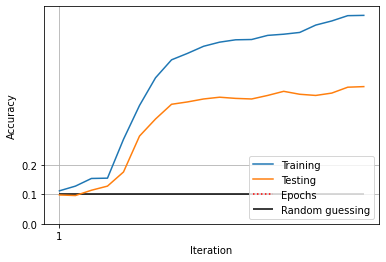

In [22]:
nn_plot_iter_acc(train_acc_dict["model_1"],
                 test_acc_dict["model_1"],
                 iteration_dict["model_1"],
                 mean_comparison = 0.1)

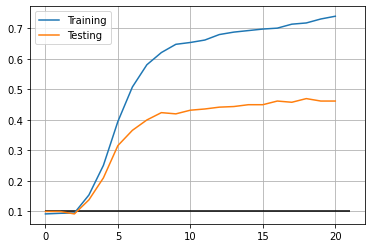

In [23]:
plt.plot(np.arange(len(mean_model_train_acc)), mean_model_train_acc, label = "Training")
plt.plot(np.arange(len(mean_model_test_acc)), mean_model_test_acc, label = "Testing")
plt.hlines(xmin = 0, xmax = len(mean_model_train_acc), y = 0.1, color = "black")
plt.legend()
plt.grid()
plt.show()

In [ ]:
nn_save(mean_model,
        "../models/enkf_model_E{}_B{}_P{}_H{}.h5".format(epochs, batch_size, particles, h_0))